### Imports

In [111]:
# main_script.py

from imports import *


In [2]:
file_path = 'udataset.xlsx'
#file_path = "new.xlsx"

In [3]:
df = pd.read_excel(file_path)
df.head()

,Substance,Substance_lower,CAS_number,Smiles_code,Additional info,Irritation,Source
0,Heptanal,heptanal,111-71-7,CCCCCCC=O,-,I,Lukáš - 2006 Howard Maibach paper.pdf
1,Lilestralis/lilial,lilestralis/lilial,80-54-6,CC(CC1=CC=C(C=C1)C(C)(C)C)C=O,-,I,NaN
2,1-Bromopentane,1-bromopentane,110-53-2,CCCCCBr,-,I,NaN
3,dl-Citronellol,dl-citronellol,106-22-9,CC(CCC=C(C)C)CCO,-,I,NaN
4,d-Limonene,d-limonene,5989-27-5,CC1=CCC(CC1)C(=C)C,-,I,NaN


### Descriptor calculation

In [4]:
def calculate_descriptors(df):
    # List to hold descriptor data for each row
    descriptor_data = []
    
    for smiles in df['Smiles_code']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            # Append a dictionary of None values for all descriptors if SMILES is invalid
            descriptor_data.append({desc[0]: None for desc in Descriptors.descList})
            continue
        
        descriptors = {}
        for descriptor, function in Descriptors.descList:
            try:
                descriptors[descriptor] = function(mol)
            except Exception:
                descriptors[descriptor] = None
        
        descriptor_data.append(descriptors)
    
    # Create a DataFrame for descriptor values with the same index as the original DataFrame
    descriptors_df = pd.DataFrame(descriptor_data, index=df.index)
    
    # Concatenate original DataFrame with descriptor DataFrame
    df = pd.concat([df, descriptors_df], axis=1)
    
    return df

In [5]:
# Function to calculate fingerprint descriptors for each row
def calculate_fingerprint(df, radius=2, n_bits=1024):
    # List to hold fingerprint data for each row
    fingerprint_data = []
    
    for smiles in df['Smiles_code']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            fingerprint_data.append([None] * n_bits)  # Append None for invalid SMILES
            continue
        
        # Calculate the Morgan fingerprint (radius 2, 1024 bits by default)
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        
        # Convert fingerprint to a list of bits
        fingerprint_data.append(list(fingerprint))
    
    # Create a DataFrame for fingerprint values
    fingerprint_df = pd.DataFrame(fingerprint_data, columns=[f'Bit_{i}' for i in range(n_bits)])
    
    # Concatenate original dataframe with fingerprint dataframe
    df = pd.concat([df, fingerprint_df], axis=1)
    
    return df

In [6]:
df = calculate_descriptors(df)
df = calculate_fingerprint(df)

[16:56:30] WARNING: not removing hydrogen atom without neighbors
[16:56:30] WARNING: not removing hydrogen atom without neighbors
[16:56:30] WARNING: not removing hydrogen atom without neighbors
[16:56:32] WARNING: not removing hydrogen atom without neighbors


In [7]:
df.head()

,Substance,Substance_lower,CAS_number,Smiles_code,Additional info,Irritation,Source,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,Heptanal,heptanal,111-71-7,CCCCCCC=O,-,I,Lukáš - 2006 Howard Maibach paper.pdf,9.768009,9.768009,0.750000,...,0,0,0,0,0,0,0,0,0,0
1,Lilestralis/lilial,lilestralis/lilial,80-54-6,CC(CC1=CC=C(C=C1)C(C)(C)C)C=O,-,I,NaN,10.535393,10.535393,0.116191,...,0,0,0,0,0,0,0,0,0,0
2,1-Bromopentane,1-bromopentane,110-53-2,CCCCCBr,-,I,NaN,3.350347,3.350347,1.167500,...,0,0,0,0,0,0,0,0,0,0
3,dl-Citronellol,dl-citronellol,106-22-9,CC(CCC=C(C)C)CCO,-,I,NaN,8.629773,8.629773,0.329353,...,0,0,0,1,0,0,0,0,0,0
4,d-Limonene,d-limonene,5989-27-5,CC1=CCC(CC1)C(=C)C,-,I,NaN,3.974575,3.974575,0.767315,...,0,0,0,1,0,1,1,0,1,0


### Data Preprocessing

In [8]:
columns_to_drop = ["Substance", "Substance_lower", "CAS_number", "Smiles_code", "Additional info", "Source"]

# Drop the columns using the drop() method with axis=1 (columns)
df = df.drop(columns_to_drop, axis=1)
df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,I,9.768009,9.768009,0.750000,0.750000,0.395123,9.125000,114.188,100.076,114.104465,...,0,0,0,0,0,0,0,0,0,0
1,I,10.535393,10.535393,0.116191,0.116191,0.689906,13.600000,204.313,184.153,204.151415,...,0,0,0,0,0,0,0,0,0,0
2,I,3.350347,3.350347,1.167500,1.167500,0.429137,9.000000,151.047,139.959,150.004412,...,0,0,0,0,0,0,0,0,0,0
3,I,8.629773,8.629773,0.329353,0.329353,0.606746,12.727273,156.269,136.109,156.151415,...,0,0,0,1,0,0,0,0,0,0
4,I,3.974575,3.974575,0.767315,0.767315,0.485034,25.800000,136.238,120.110,136.125201,...,0,0,0,1,0,1,1,0,1,0


In [9]:
columns_to_drop = ["BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW"]

# Drop the columns using the drop() method with axis=1 (columns)
df = df.drop(columns_to_drop, axis=1)

In [10]:
def drop_columns(df):
    columns_to_drop = ["Substance", "Substance_lower", "CAS_number", "Smiles_code", "Additional info", "Source"]

    #   Drop the columns using the drop() method with axis=1 (columns)
    df = df.drop(columns_to_drop, axis=1)

    columns_to_drop = ["BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW"]

    # Drop the columns using the drop() method with axis=1 (columns)
    df = df.drop(columns_to_drop, axis=1)

    # Calculate the percentage of zeros for each column
    zero_percentage = (df.isin([0]).sum() / len(df)) * 100
    columns_to_keep = zero_percentage[zero_percentage <= 90].index
    df = df[columns_to_keep]

    return df

In [11]:
# Count the number of rows before dropping NaN values
num_rows_before = df.shape[0]

# Drop rows with NaN values
df.dropna(inplace=True)

# Count the number of rows after dropping NaN values
num_rows_after = df.shape[0]

# Calculate the number of rows dropped
num_rows_dropped = num_rows_before - num_rows_after

print("Number of rows dropped:", num_rows_dropped)

Number of rows dropped: 4


In [12]:
def detect_outliers(df):
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outlier_mask = (df < lower_bound) | (df > upper_bound)
    
    # Replace outliers with median
    median_values = df.median(axis=1)
    df = df.where(~outlier_mask, median_values, axis=0)


    outliers = df[outlier_mask.any(axis=1)]
    num_outliers = outliers.shape[0]
    print(f"Number of outliers detected: {num_outliers}")

    return df

In [13]:

df['Irritation'] = df['Irritation'].replace({'I': 1, 'NI': 0})
df.head()

/var/folders/n4/lx5wz8kj2r79g9p8wxdnqk580000gn/T/ipykernel_40324/744444035.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Irritation'] = df['Irritation'].replace({'I': 1, 'NI': 0})


,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,1,9.768009,9.768009,0.750000,0.750000,0.395123,9.125000,114.188,100.076,114.104465,...,0,0,0,0,0,0,0,0,0,0
1,1,10.535393,10.535393,0.116191,0.116191,0.689906,13.600000,204.313,184.153,204.151415,...,0,0,0,0,0,0,0,0,0,0
2,1,3.350347,3.350347,1.167500,1.167500,0.429137,9.000000,151.047,139.959,150.004412,...,0,0,0,0,0,0,0,0,0,0
3,1,8.629773,8.629773,0.329353,0.329353,0.606746,12.727273,156.269,136.109,156.151415,...,0,0,0,1,0,0,0,0,0,0
4,1,3.974575,3.974575,0.767315,0.767315,0.485034,25.800000,136.238,120.110,136.125201,...,0,0,0,1,0,1,1,0,1,0


In [14]:
df = detect_outliers(df)

Number of outliers detected: 442


In [15]:

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the DataFrame
normalized_data = scaler.fit_transform(df)

# Convert the scaled data back to a DataFrame
df = pd.DataFrame(normalized_data, columns=df.columns)

df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,1.0,0.648191,0.648191,0.841558,0.816337,0.378529,0.466241,0.209837,0.183848,0.210562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.699113,0.699113,0.130376,0.702564,0.713980,0.694891,0.375455,0.338304,0.376730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.000000,0.000000,0.000000,0.891282,0.417235,0.459854,0.277571,0.257116,0.276810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.572659,0.572659,0.369560,0.740828,0.619348,0.650299,0.287167,0.250043,0.288153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.263747,0.263747,0.860987,0.819445,0.480844,0.000000,0.250357,0.220652,0.251198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:

def feature_selection(df):
    nonzero_thrd=0.01
    cor_thrd=0.9
    print(f"Original shape of data: {df.shape}")
    
    # Step 1: Remove features with low variance
    nonzero_df = df.loc[:, df.var() > nonzero_thrd]
    print(f"Removed {df.shape[1] - nonzero_df.shape[1]} features with variance <= {nonzero_thrd}")
    
    # Step 2: Remove highly correlated features
    corr_matrix = nonzero_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > cor_thrd)]
    print(f"Removed {len(to_drop)} highly correlated features with correlation > {cor_thrd}")
    
    # Step 3: Return the cleaned dataset
    cleaned_df = nonzero_df.drop(to_drop, axis=1)
    print(f"Final shape of data: {cleaned_df.shape}")
    return cleaned_df


df = feature_selection(df)
df.head()

Original shape of data: (442, 1227)
Removed 1113 features with variance <= 0.01
Removed 22 highly correlated features with correlation > 0.9
Final shape of data: (442, 92)


,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,Bit_33,Bit_80,Bit_356,Bit_389,Bit_650,Bit_695,Bit_726,Bit_807,Bit_849,Bit_893
0,1.0,0.648191,0.841558,0.816337,0.378529,0.466241,0.209837,0.330770,0.548769,0.461214,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.699113,0.130376,0.702564,0.713980,0.694891,0.375455,0.334665,0.549237,0.460735,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.000000,0.000000,0.891282,0.417235,0.459854,0.277571,0.186114,1.000000,0.000000,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.572659,0.369560,0.740828,0.619348,0.650299,0.287167,0.236064,0.410511,0.602531,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.263747,0.860987,0.819445,0.480844,0.000000,0.250357,0.160976,1.000000,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


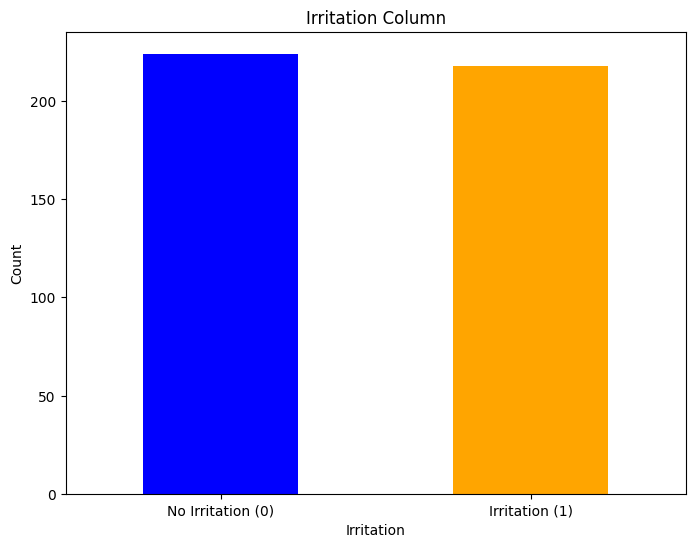

In [17]:
# Plotting class imbalance
plt.figure(figsize=(8, 6))
df['Irritation'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Irritation Column')
plt.xlabel('Irritation')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Irritation (0)', 'Irritation (1)'], rotation=0)
plt.show()

### Train Test Datasets

In [18]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [212]:
#from sklearn.datasets import make_classification
#X, y = make_classification(n_samples=1000, n_features=20)

In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (353, 91)
Shape of X_test: (89, 91)
Shape of y_train: (353,)
Shape of y_test: (89,)


In [20]:
y_train

1      1.0
373    0.0
94     1.0
366    0.0
307    0.0
      ... 
314    0.0
425    1.0
333    0.0
162    0.0
19     1.0
Name: Irritation, Length: 353, dtype: float64

## Optuna

In [ ]:
# Define the objective function for Optuna with cross-validation
def objective(trial):
    # Define the hyperparameter space
    params = {
        'objective': 'binary:logistic',  # Change this if using a different task
        'eval_metric': 'logloss',       # Metric for evaluation
        'use_label_encoder': False,     # Disable XGBoost warning
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }

    # Create an XGBoost classifier with the suggested parameters
    model = xgb.XGBClassifier(**params)

    # Perform cross-validation and return the average accuracy across the folds
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
    return score.mean()

# Create a study and optimize it
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

# Train final model with best parameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy on Test Set:", final_accuracy)

In [ ]:
# Best parameters from Trial 2
best_params = {'max_depth': 3, 'learning_rate': 0.20062377499343031, 'n_estimators': 209, 'min_child_weight': 1, 'gamma': 0.5656233867993066, 'subsample': 0.8463948403485265, 'colsample_bytree': 0.7064697839968391, 'lambda': 0.027744343804509183, 'alpha': 0.38774496135644}

# Initialize and train the model with the best parameters
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy on the test set
final_accuracy = accuracy_score(y_test, y_pred)
print(final_accuracy)

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Number of trees
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Maximum depth of the trees
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),  # Min samples to split a node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),  # Min samples to be at a leaf node
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),  # Fixed choices for max_features
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])  # Bootstrap sampling
    }

    # Create a RandomForestClassifier with the suggested parameters
    model = RandomForestClassifier(**params)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study and optimize it
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

# Train final model with best parameters
best_params = study.best_params
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy:", final_accuracy)

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter space
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),  # Splitting criteria
        'max_depth': trial.suggest_int('max_depth', 3, 20),  # Maximum depth of the tree
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),  # Min samples required to split an internal node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),  # Min samples required to be at a leaf node
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),  # Max features for splits
        'splitter': trial.suggest_categorical('splitter', ['best', 'random'])  # Splitter strategy
    }

    # Create a DecisionTreeClassifier with the suggested parameters
    model = DecisionTreeClassifier(**params)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study and optimize it
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

# Train final model with best parameters
best_params = study.best_params
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy:", final_accuracy)

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter space
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 20),  # Number of neighbors to use
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),  # Weight function used in prediction
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),  # Algorithm used to compute the nearest neighbors
        'p': trial.suggest_int('p', 1, 2),  # Power parameter for the Minkowski distance
    }

    # Create a KNeighborsClassifier with the suggested parameters
    model = KNeighborsClassifier(**params)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study and optimize it
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

# Train final model with best parameters
best_params = study.best_params
best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy:", final_accuracy)

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter space
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])  # Kernel type
    
    # Hyperparameters common across all kernels
    params = {
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),  # Regularization parameter, on a log scale
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel != 'linear' else 'scale',  # Kernel coefficient
    }

    # Specific hyperparameters for the 'poly' kernel
    if kernel == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 5)  # Degree for polynomial kernel
    
    # Set kernel type in the params
    params['kernel'] = kernel

    # Create an SVM classifier with the suggested parameters
    model = SVC(**params)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study and optimize it
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

# Train final model with best parameters
best_params = study.best_params
best_model = SVC(**best_params)
best_model.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy:", final_accuracy)

In [ ]:
# Stratifikovaný K-fold cross-validation (5-fold)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Premenné pre ukladanie výsledkov
accuracies = []

# Iterujeme cez K-fold
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]  # Používame iloc na pandas DataFrame
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]  # Rovnaké pre y

    # Vytvorenie modelu XGBoost
    model = xgb.XGBClassifier(
        objective='binary:logistic',  # alebo podľa potreby iný objective
        eval_metric='logloss',         # môžete zmeniť na presnejší eval_metric
        early_stopping_rounds=10,      # Skoro zastavenie, ak sa validácia nezlepšuje
        n_estimators=100,             # Maximálny počet iterácií
        random_state=42
    )

    # Tréning modelu s early stopping
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Predikcia na validačných dátach
    y_pred = model.predict(X_val)

    # Hodnotenie presnosti
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    print(f"Validation accuracy: {accuracy:.4f}")

# Priemerná presnosť cez všetky foldy
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy:.4f}")

In [ ]:
# Stratifikovaný K-fold cross-validation (5-fold)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Premenné pre ukladanie výsledkov
accuracies = []

# Iterujeme cez K-fold
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]  # Používame iloc na pandas DataFrame
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]  # Rovnaké pre y

    # Vytvorenie modelu XGBoost
    model = xgb.XGBClassifier(
        objective='binary:logistic',  # alebo podľa potreby iný objective
        eval_metric='logloss',         # môžete zmeniť na presnejší eval_metric
        early_stopping_rounds=10,      # Skoro zastavenie, ak sa validácia nezlepšuje
        n_estimators=100,             # Maximálny počet iterácií
        random_state=42
    )

    # Tréning modelu s early stopping
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Predikcia na validačných dátach
    y_pred = model.predict(X_val)

    # Hodnotenie presnosti
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    print(f"Validation accuracy: {accuracy:.4f}")

# Priemerná presnosť cez všetky foldy
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy:.4f}")

### print_score

In [131]:
# Function to print evaluation metrics and cross-validation results
def print_score(y_train, y_pred_train, y_test, y_pred_test, grid_search=None, y_prob_test=None):
    print("\nGridSearchCV Summary:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
    # Evaluate the model on training data
    train_accuracy = accuracy_score(y_train, y_pred_train)
    print("Training Accuracy:", train_accuracy)
    print("Training Classification Report:")
    print(classification_report(y_train, y_pred_train))
    print("Training Confusion Matrix:")
    print(confusion_matrix(y_train, y_pred_train))
    print("\n")  # Separate training and testing output
    
    # Evaluate the model on testing data
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print("Testing Accuracy:", test_accuracy)
    print("Testing Classification Report:")
    print(classification_report(y_test, y_pred_test))
    print("Testing Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_test))

    roc_auc = roc_auc_score(y_test, y_prob_test)
    print(f"ROC-AUC Score on Test Set: {roc_auc:.4f}")
        



In [107]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def print_score(y_train, y_pred_train, y_test, y_pred_test):    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    # Evaluate the model on testing data
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    
    # Print Testing results
    print("\nTesting Results:")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-Score: {test_f1:.4f}")


In [ ]:
# Shuffle the dataset
X, y = shuffle(X, y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize models
xgboost_model = xgb.XGBClassifier(random_state=42, n_jobs=1)
random_forest = RandomForestClassifier(random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
knn_model =  KNeighborsClassifier()
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced')

# List of models for evaluation
models = {
    "XGBoost": xgboost_model,
    "Random Forest": random_forest,
    "Decision Tree": decision_tree,
    "KNN":knn_model,
    "SVM":svm_model
}

# Metrics for cross-validation
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

# Cross-validation and testing accuracy for each model
for model_name, model in models.items():
    print(f"\n### {model_name} ###")
    
    # Perform cross-validation for each metric
    for metric in scoring_metrics:
        cv_scores = cross_val_score(model, X, y, cv=15, scoring=metric)
        print(f"Average {metric}: {cv_scores.mean()}")
    
    # Train the model on the training set
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_test_pred = model.predict(X_test)
    
    # Calculate and print test accuracy
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Testing accuracy: {test_accuracy}")

In [ ]:
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

def optimize_num_features(X_train, y_train, model, max_features=600, step=15, n_splits=10):
    """
    Optimalizuje počet features pomocou SHAP a krosvalidácie.

    Parameters:
        X_train: DataFrame s trénovacími dátami.
        y_train: Series s cieľovými hodnotami.
        model: Model (napr. XGBClassifier).
        max_features: Maximálny počet features na otestovanie.
        step: Krok na znižovanie počtu features.
        n_splits: Počet krosvalidačných splitov.

    Returns:
        optimal_features: Optimálny počet features.
        feature_accuracies: Slovník obsahujúci počet features a ich priemernú presnosť.
    """
    # Slovník na uloženie priemerných presností pre rôzne počty features
    feature_accuracies = {}

    # Postupné testovanie rôznych počtov features
    for num_top_features in range(step, max_features + 1, step):
        print(f"Testing top {num_top_features} features...")
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

        # Na uloženie presností v jednotlivých foldoch
        all_fold_accuracies = []

        for train_idx, val_idx in skf.split(X_train, y_train):
            # Rozdelenie na trénovací a validačný set
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Trénovanie modelu
            model.fit(X_train_fold, y_train_fold)

            # Výpočet SHAP hodnôt
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_train_fold)

            # Výpočet dôležitosti features
            shap_importance = np.abs(shap_values).mean(axis=0)
            feature_importance = pd.DataFrame(
                list(zip(X_train.columns, shap_importance)),
                columns=['Feature', 'Importance']
            )
            feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
            top_features = feature_importance['Feature'].head(num_top_features).tolist()

            # Použitie vybraných features
            X_train_fold_selected = X_train_fold[top_features]
            X_val_fold_selected = X_val_fold[top_features]

            # Trénovanie modelu na zvolených features
            model.fit(X_train_fold_selected, y_train_fold)
            y_pred_fold = model.predict(X_val_fold_selected)

            # Výpočet presnosti
            fold_accuracy = accuracy_score(y_val_fold, y_pred_fold)
            all_fold_accuracies.append(fold_accuracy)

        # Priemerná presnosť pre aktuálny počet features
        avg_accuracy = np.mean(all_fold_accuracies)
        feature_accuracies[num_top_features] = avg_accuracy
        print(f"Average accuracy with top {num_top_features} features: {avg_accuracy:.4f}")

    # Nájdeme optimálny počet features
    optimal_features = max(feature_accuracies, key=feature_accuracies.get)
    print(f"\nOptimal number of features: {optimal_features} with accuracy: {feature_accuracies[optimal_features]:.4f}")

    return optimal_features, feature_accuracies

# Príklad použitia
# X_train a y_train by mali byť vaše dáta
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

optimal_features, feature_accuracies = optimize_num_features(
    X_train, y_train, xgboost_model, max_features=600, step=15, n_splits=15
)

## XGBoost

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [22]:
roc_data_list = []

In [23]:
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb

def xgboost(X_train, X_test, y_train, y_test):
    param_grid = {
        'learning_rate': [0.01, 0.05],  # Lower learning rate
        'max_depth': [3],  # Shallower trees
        'n_estimators': [100, 150],  # More boosting rounds
        'min_child_weight': [4, 5],  # Higher value to reduce overfitting
        'subsample': [0.5, 0.6],  # Lower subsampling
        'colsample_bytree': [0.5, 0.6],  # Fewer features per tree
        'reg_alpha': [0.5, 1.0],  # Stronger L1 regularization
        'reg_lambda': [2.0, 3.0],  # Stronger L2 regularization
    }

    # Rozdelenie trénovacích dát na tréningové a validačné sety pre early stopping
    X_train_inner, X_val, y_train_inner, y_val = train_test_split(
        X_train, y_train, test_size=0.2
    )

    # GridSearchCV s 5-fold cross-validation
    xgboost_model = xgb.XGBClassifier()
    grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train_inner, y_train_inner)

    # Najlepšie parametre
    best_params = grid_search.best_params_

    # Finálny model s najlepšími parametrami
    final_model = xgb.XGBClassifier(
        **best_params,
        early_stopping_rounds=10,
        eval_metric="logloss",
        use_label_encoder=False  # Novšie verzie XGBoost vyžadujú toto vypnuté
    )

    # Trénovanie finálneho modelu na tréningových + validačných dátach
    final_model.fit(
        X_train_inner,
        y_train_inner,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Predikcie
    y_pred_test_xgboost = final_model.predict(X_test)
    y_pred_train_xgboost = final_model.predict(X_train)

    # Pravdepodobnosti pre testovací set
    y_prob_test = final_model.predict_proba(X_test)[:, 1]
    # Get predicted probabilities for the positive class

    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    roc_auc = auc(fpr, tpr)

    # Smooth the TPR using Gaussian smoothing
    tpr_smooth = gaussian_filter1d(tpr, sigma=2)
    
    # Save the ROC curve data to the list
    roc_data_list.append({
        'descriptory': len(X_train.columns),
        'fpr': fpr,
        'tpr': tpr_smooth,
        'roc_auc': roc_auc
    })
    # Vyhodnotenie
    print_score(y_train, y_pred_train_xgboost, y_test, y_pred_test_xgboost, grid_search, y_prob_test)
    
    return final_model


In [24]:
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc
import xgboost as xgb

def xgboost(X, y):
    # Define the XGBoost classifier
    xgboost_model = xgb.XGBClassifier()

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Cross-validation strategy (StratifiedKFold)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Perform cross-validated prediction of probabilities on the training set
    y_prob_cv = cross_val_predict(xgboost_model, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

    # Compute the ROC curve based on cross-validated probabilities
    fpr_cv, tpr_cv, _ = roc_curve(y_train, y_prob_cv)
    roc_auc_cv = auc(fpr_cv, tpr_cv)

    print(f"Cross-validated AUC (Training Set): {roc_auc_cv}")

    # Train the model on the entire training dataset
    xgboost_model.fit(X_train, y_train)

    # Get predicted probabilities on the test set
    y_prob_test = xgboost_model.predict_proba(X_test)[:, 1]

    # Compute the ROC curve for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    print(f"Final Test AUC: {roc_auc_test}")

    # Save the ROC curve data to the list
    roc_data_list.append({
        'descriptory': "Xgboost",
        'fpr': fpr_cv,
        'tpr': tpr_cv,
        'roc_auc': roc_auc_cv
    })

    return xgboost_model


In [99]:
model = xgboost(X,y)

Cross-validated AUC (Training Set): 0.8938708020291531
Final Test AUC: 0.9565656565656566


In [100]:
def feature_selection(features, model):
    # Create SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X)

    # Calculate feature importance
    vals = np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['col_name', 'feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

    # Extract top important features
    top_features = feature_importance['col_name'].head(features).tolist()

    # Filter training and validation data to include only top important features
    x_selected = X[top_features]
    return x_selected

In [101]:
X_selected = feature_selection(50, model)
model = xgboost(X_selected,y)

Cross-validated AUC (Training Set): 0.9029891478841584
Final Test AUC: 0.9474747474747475


In [93]:
roc_data_list.pop(-1)

{'descriptory': 91,
 'fpr': array([0.        , 0.09090909, 0.15909091, 0.20454545, 0.40909091,
        0.59090909, 1.        ]),
 'tpr': array([0.        , 0.44444444, 0.71111111, 0.8       , 0.91111111,
        1.        , 1.        ]),
 'roc_auc': 0.8517676767676767}

In [97]:
roc_data_list[-1]['descriptory'] = "SVM"

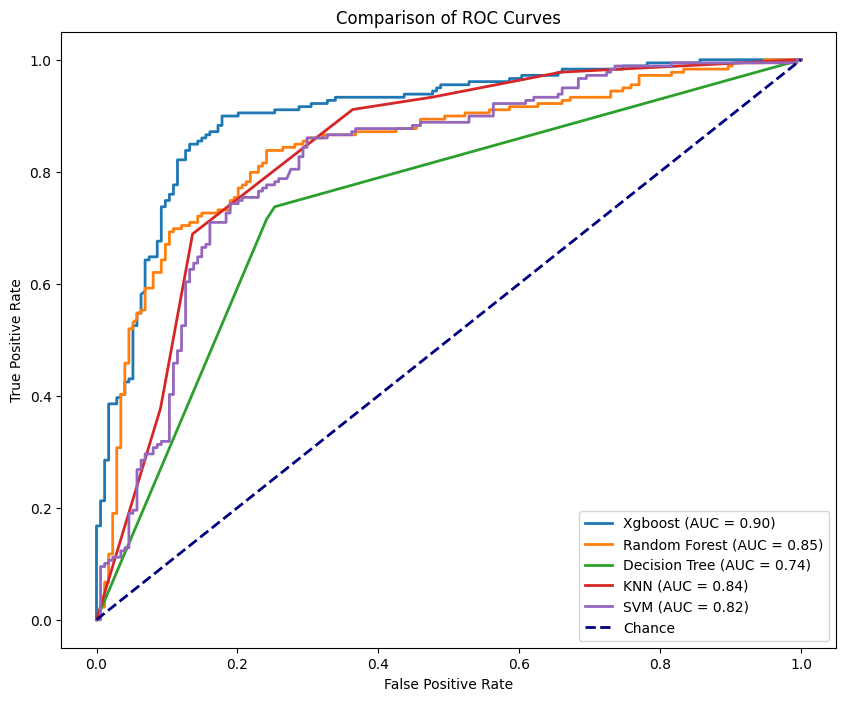

In [98]:
# Plot all ROC curves together
plt.figure(figsize=(10, 8))
for roc_data in roc_data_list:
    plt.plot(
        roc_data['fpr'], roc_data['tpr'],
        lw=2, label=f"{roc_data['descriptory']} (AUC = {roc_data['roc_auc']:.2f})"
    )

# Plot the chance line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves')
plt.legend(loc='lower right')
plt.show()

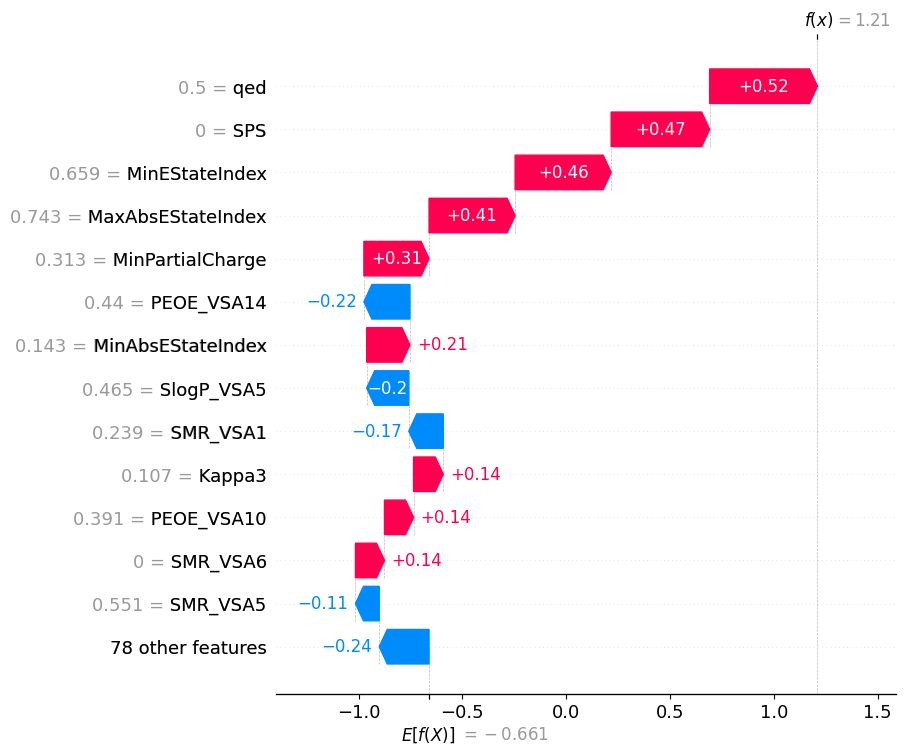

In [102]:

X100 = shap.utils.sample(X, 100)
sample_ind = 20
explainer_xgb = shap.Explainer(model, X100)
shap_values_xgb = explainer_xgb(X)
shap.plots.waterfall(shap_values_xgb[sample_ind], max_display=14)


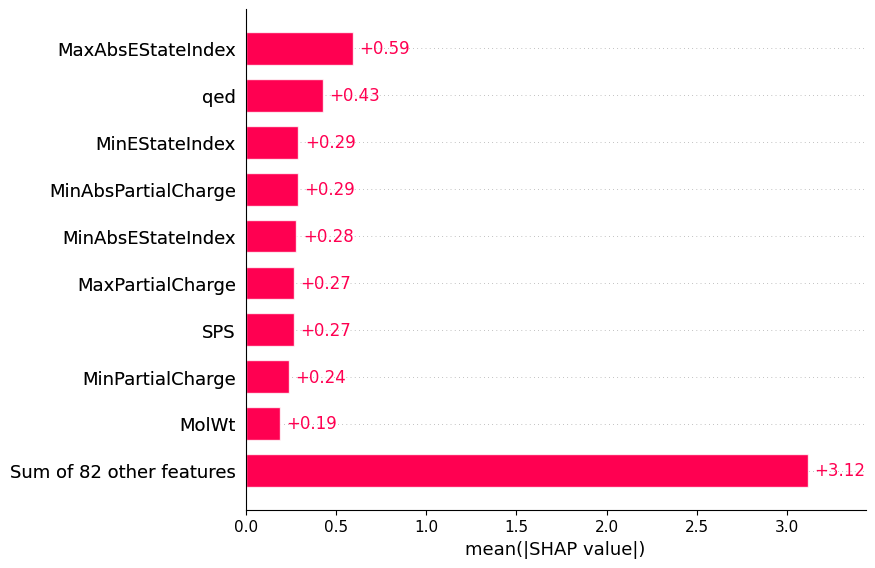

In [103]:
#absolutna hodnota aj kladnej aj zapornej
shap.plots.bar(shap_values_xgb)

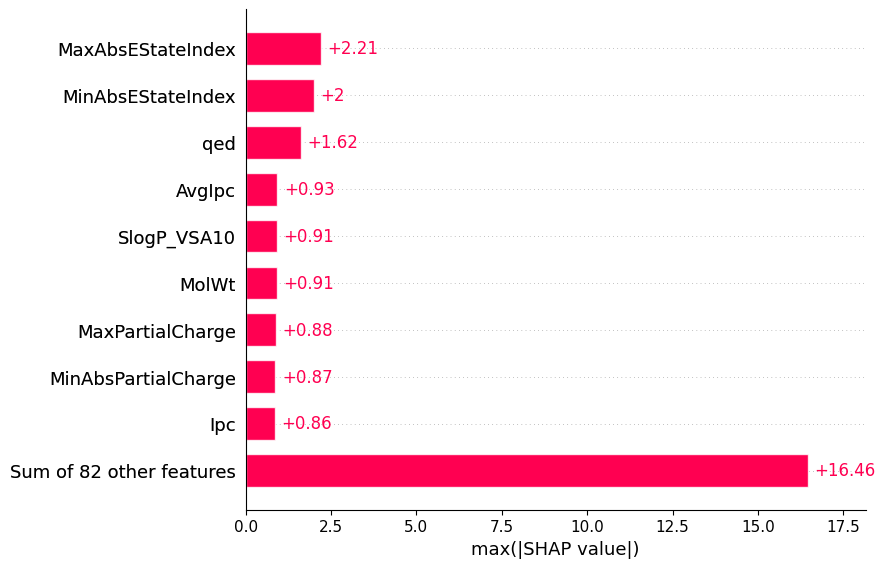

In [104]:
#kladne iba
shap.plots.bar(shap_values_xgb.abs.max(0))

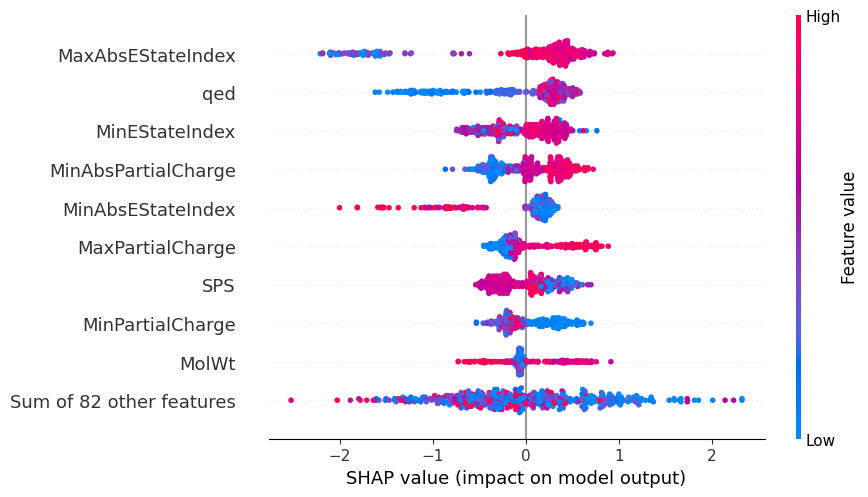

In [105]:
#Distribucia pre zložitejšie prípady 
shap.plots.beeswarm(shap_values_xgb)

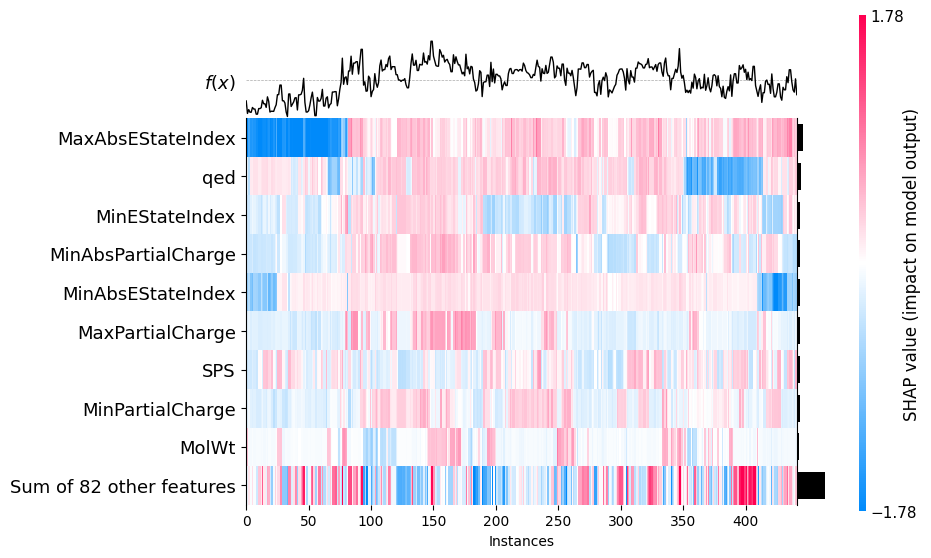

In [106]:
shap.plots.heatmap(shap_values_xgb[:1000])

# order descriptors

In [31]:
def order_descriptors(shap_values, df):
    # Convert SHAP values to absolute values and calculate mean
    abs_shap_values = np.abs(shap_values)
    mean_abs_shap_values = np.mean(abs_shap_values, axis=0)

    # Get column names from df
    column_names = df.columns

    # Calculate mean importance across all samples
    mean_importance = np.mean(mean_abs_shap_values, axis=0)

    # Combine feature names with mean SHAP values
    feature_importance_df = pd.DataFrame({'Feature': column_names, 'Mean_Shap_Value': mean_importance})

    # Sort features by mean importance in descending order
    sorted_features = feature_importance_df.sort_values(by='Mean_Shap_Value', ascending=False)


    return  sorted_features

In [32]:
def feature_selection(features, model):
    # Create SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X)
    shap_values = np.swapaxes(np.swapaxes(shap_values, 0, 2), 1, 2)

    sorted_features = order_descriptors(shap_values, X)
    print(sorted_features.head(features))

    top_features = sorted_features["Feature"].head(features).tolist()

    X_selected =  X[top_features]

    return X_selected

## Random Forest

In [1156]:
roc_data_list = []

In [1269]:
roc_data_list = sorted(roc_data_list, key=lambda x: x['descriptory'])


In [ ]:
print(roc_data_list)

In [35]:
def random_forest(X_train, X_test, y_train, y_test):
        # Definícia mriežky hyperparametrov
    param_grid = {
        'n_estimators': [100, 150, 200],  # Viac stromov
        'max_depth': [5, 8, 10],  # Hĺbka stromov
        'min_samples_split': [10, 15, 20],  # Minimálny počet vzoriek na rozdelenie
        'min_samples_leaf': [10, 15],  # Minimálny počet vzoriek v listoch
        'max_features': ['sqrt', 'log2'],  # Počet vlastností na rozdelenie
        'class_weight': ['balanced', 'balanced_subsample'],  # Vyváženie tried
    }

    # Inicializácia Random Forest Classifier
    rf = RandomForestClassifier()

    # Nastavenie Stratified K-Fold cross-validácie
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    # GridSearchCV pre hľadanie najlepších hyperparametrov
    grid_search = GridSearchCV(
        estimator=rf, 
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        verbose=1, 
        scoring='roc_auc'  # Použijeme ROC-AUC na hodnotenie modelov
    )

    # Trénovanie GridSearchCV na trénovacích dátach
    grid_search.fit(X_train, y_train)

    # Finálny model s najlepšími parametrami
    rf_model = grid_search.best_estimator_

    # Perform predictions on the training dataset
    y_pred_train_rf = rf_model.predict(X_train)

    # Make predictions on the test set
    y_pred_test_rf = rf_model.predict(X_test)
    
    # Get predicted probabilities
    y_prob_test_rf = rf_model.predict_proba(X_test)[:, 1]

    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob_test_rf)
    roc_auc = auc(fpr, tpr)

    # Smooth the TPR using Gaussian smoothing
    tpr_smooth = gaussian_filter1d(tpr, sigma=2)
    
    # Save the ROC curve data to the list
    roc_data_list.append({
        'descriptory': len(X_train.columns),
        'fpr': fpr,
        'tpr': tpr_smooth,
        'roc_auc': roc_auc
    })

    print_score(y_train, y_pred_train_rf, y_test, y_pred_test_rf, grid_search, y_prob_test_rf)

    return rf_model

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, learning_curve, validation_curve
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

def randomforest(X, y):
    # Define the Random Forest classifier with predefined hyperparameters
    rf = RandomForestClassifier(
        n_estimators=300,         # Number of trees in the forest
        max_depth=5,             # Maximum depth of the tree
        min_samples_split=50,      # Minimum samples required to split an internal node
        min_samples_leaf=10,       # Minimum samples required at each leaf node
        max_features='sqrt',      # Number of features to consider for the best split
        bootstrap=True,           # Whether bootstrap samples are used when building trees
        random_state=42           # Ensure reproducibility
    )

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    # Cross-validation strategy (StratifiedKFold)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Perform cross-validated prediction of probabilities on the training set
    y_prob_cv = cross_val_predict(rf, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

    # Compute the ROC curve based on cross-validated probabilities
    fpr_cv, tpr_cv, _ = roc_curve(y_train, y_prob_cv)
    roc_auc_cv = auc(fpr_cv, tpr_cv)

    # Compute accuracy for cross-validation
    y_pred_cv = cross_val_predict(rf, X_train, y_train, cv=cv, method='predict', n_jobs=-1)
    accuracy_cv = accuracy_score(y_train, y_pred_cv)

    print(f"Cross-validated AUC (Training Set): {roc_auc_cv}")
    print(f"Cross-validated Accuracy (Training Set): {accuracy_cv}")

    # Train the model on the entire training dataset
    rf.fit(X_train, y_train)

    # Get predicted probabilities on the test set
    y_prob_test = rf.predict_proba(X_test)[:, 1]

    # Compute the ROC curve for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Compute accuracy for the test set
    y_pred_test = rf.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    print(f"Final Test AUC: {roc_auc_test}")
    print(f"Final Test Accuracy: {accuracy_test}")

    # Save the ROC curve data to the list
    roc_data_list.append({
        'descriptory': len(X_train.columns),
        'fpr': fpr_cv,
        'tpr': tpr_cv,
        'roc_auc': roc_auc_cv
    })

    # ---- Added Plots ----

    # 1. Learning Curves
    train_sizes, train_scores, validation_scores = learning_curve(
        rf, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    validation_mean = np.mean(validation_scores, axis=1)
    validation_std = np.std(validation_scores, axis=1)

    plt.figure(figsize=(12, 6))
    plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
    plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
    plt.title('Learning Curve (Training vs Validation Accuracy)')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


    # 3. ROC Curve (Training vs Validation)
    y_prob_train = rf.predict_proba(X_train)[:, 1]
    y_prob_val = rf.predict_proba(X_test)[:, 1]

    fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
    fpr_val, tpr_val, _ = roc_curve(y_test, y_prob_val)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_val = auc(fpr_val, tpr_val)

    plt.figure(figsize=(12, 6))
    plt.plot(fpr_train, tpr_train, color='blue', label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')
    plt.plot(fpr_val, tpr_val, color='green', label=f'Validation ROC curve (AUC = {roc_auc_val:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
    plt.title('ROC Curve (Training vs Validation)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return rf


Cross-validated AUC (Training Set): 0.8455178835163424
Cross-validated Accuracy (Training Set): 0.7847025495750708
Final Test AUC: 0.8631313131313132
Final Test Accuracy: 0.8202247191011236


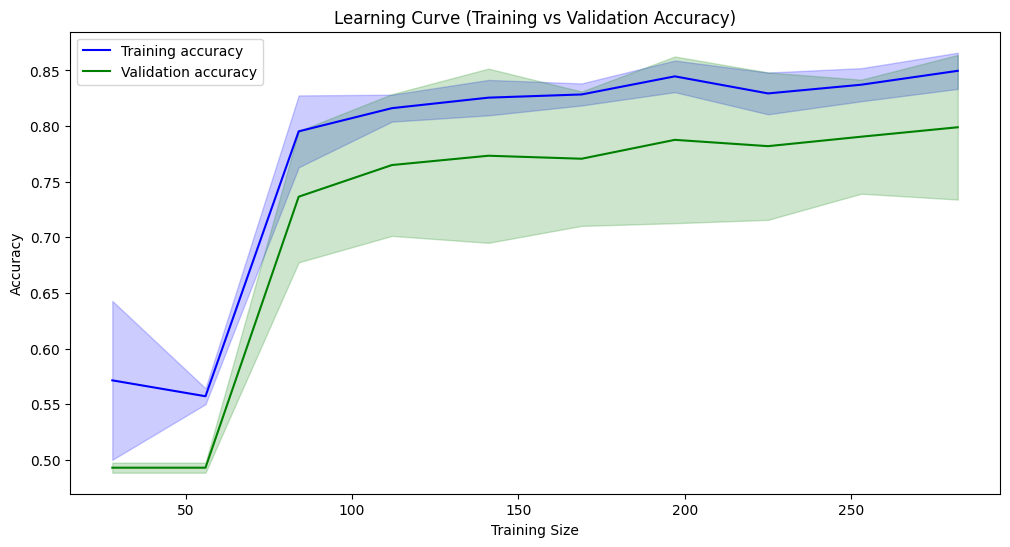

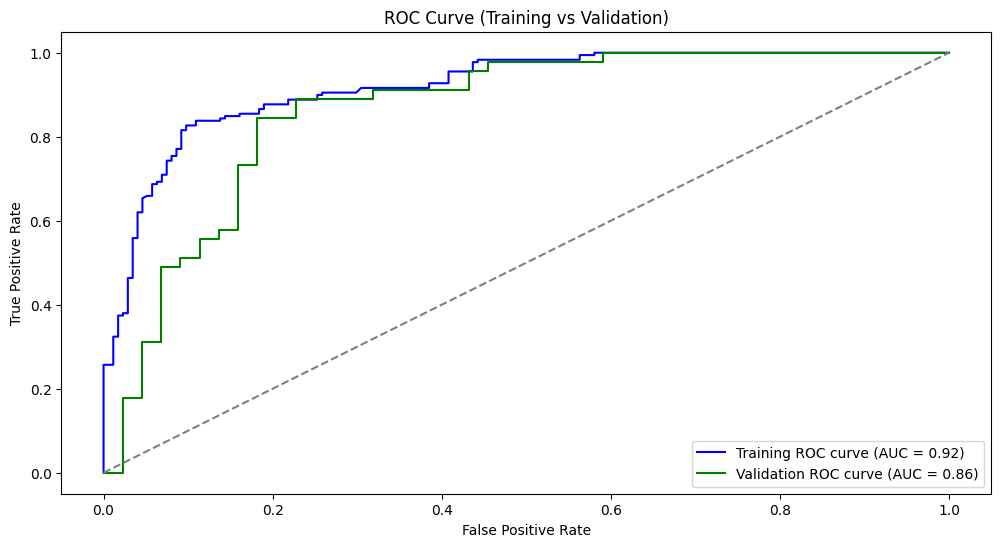

In [37]:
model = randomforest(X,y)

In [ ]:
X_selected = feature_selection(2, model)
model = randomforest(X_selected,y)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_selected)
print(shap_values.shape)
print(X_train_selected.shape)


In [ ]:
shap.summary_plot(shap_values[:,:,1], X_train_selected)

In [ ]:
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index,:,1], base_values=explainer.expected_value[1], data=X_test.iloc[index,:]), max_display=20)

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[index,:,1], feature_names=X_train_selected.columns, matplotlib=True, show=False)

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Accessing the first decision tree
first_tree = model.estimators_[0]  

# Adjusting the figure size
plt.figure(figsize=(20,20))

# Plotting the entire tree
plot_tree(first_tree, feature_names=model.feature_names_in_, filled=True)

# Saving the tree visualization to an image file
plt.savefig('decision_tree.png')

# Displaying the tree visualization
plt.show()


## Decision Tree

In [1236]:
roc_data_list = []

In [ ]:
print(roc_data_list)

In [41]:
def decision_tree(X_train, X_test, y_train, y_test):

    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [2, 3],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 5, 10],
        'max_features': ['sqrt', 'log2', None],
        'min_impurity_decrease': [0, 0.001, 0.01],
        'class_weight': [None, 'balanced']
    }

    
    # Initialize the DecisionTreeClassifier
    dt = DecisionTreeClassifier(random_state=42)

    # Define StratifiedKFold for cross-validation (ensures equal class distribution across folds)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring='accuracy')

    # Run the grid search to find the best hyperparameters
    grid_search.fit(X_train, y_train)

    # Best model from the grid search
    tree_model = grid_search.best_estimator_

    # Predikcie na trénovacej množine
    y_pred_train_tree= tree_model.predict(X_train)

    # Predikcie na testovacej množine
    y_pred_test_tree = tree_model.predict(X_test)

    # Get predicted probabilities
    y_prob_test_tree = tree_model.predict_proba(X_test)[:, 1]

    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob_test_tree)
    roc_auc = auc(fpr, tpr)

    # Smooth the TPR using Gaussian smoothing
    tpr_smooth = gaussian_filter1d(tpr, sigma=2)
    
    # Save the ROC curve data to the list
    roc_data_list.append({
        'descriptory': len(X_train.columns),
        'fpr': fpr,
        'tpr': tpr_smooth,
        'roc_auc': roc_auc
    })

    
    print_score(y_train, y_pred_train_tree, y_test, y_pred_test_tree, grid_search, y_prob_test_tree)
    return tree_model


In [42]:
def decisiontree(X, y):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
    from sklearn.metrics import roc_curve, auc

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Define the Decision Tree classifier
    dt = DecisionTreeClassifier()

    # Cross-validation strategy (StratifiedKFold)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validated prediction of probabilities on the training set
    try:
        y_prob_cv = cross_val_predict(dt, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    except IndexError:
        # If there are only two classes, ensure probabilities are correctly extracted
        y_prob_cv = cross_val_predict(dt, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

    # Compute the ROC curve based on cross-validated probabilities
    fpr_cv, tpr_cv, _ = roc_curve(y_train, y_prob_cv)
    roc_auc_cv = auc(fpr_cv, tpr_cv)

    print(f"Cross-validated AUC (Training Set): {roc_auc_cv}")

    # Train the model on the entire training dataset
    dt.fit(X_train, y_train)

    # Get predicted probabilities on the test set
    y_prob_test = dt.predict_proba(X_test)[:, 1]

    # Compute the ROC curve for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    print(f"Final Test AUC: {roc_auc_test}")

    # Save the ROC curve data to the list
    roc_data_list.append({
        'descriptory': len(X_train.columns),
        'fpr': fpr_cv,
        'tpr': tpr_cv,
        'roc_auc': roc_auc_cv
    })

    return dt


In [43]:
tree_model = decisiontree(X,y)

Cross-validated AUC (Training Set): 0.7436910036601809
Final Test AUC: 0.7972222222222222


In [ ]:
roc_data_list.pop(1)

In [44]:
X_selected = feature_selection(10, tree_model)
new_tree_model = decisiontree(X_selected, y)

                Feature  Mean_Shap_Value
16        HallKierAlpha         0.160843
66              NOCount         0.129607
37           SlogP_VSA1         0.067798
58          VSA_EState3         0.058059
12     FpDensityMorgan3         0.055462
6      MaxPartialCharge         0.052785
13               AvgIpc         0.051369
8   MaxAbsPartialCharge         0.031497
18               Kappa2         0.021622
14             BalabanJ         0.017806
Cross-validated AUC (Training Set): 0.7956719964040326
Final Test AUC: 0.8313131313131313


## KNN

In [46]:
class ModelWrapper:
    def __init__(self, model):
        self.model = model
        
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

wrapped_model = ModelWrapper(knn_model)


NameError: name 'knn_model' is not defined

In [47]:
def kernel_feature_selection(model):
    background_summary = shap.sample(X, 100)
    explainer = shap.KernelExplainer(model.predict_proba, background_summary)

    shap_values = explainer.shap_values(X_train)
    shap_values = np.swapaxes(np.swapaxes(shap_values, 0, 2), 1, 2)
    #shap.summary_plot(shap_values, X_train)


    sorted_features = order_descriptors(shap_values, X_train)
    return sorted_features

In [48]:
def get_features(num_features, sorted_features):
    print(sorted_features.head(num_features))

    top_features = sorted_features["Feature"].head(num_features).tolist()

    X_selected =  X[top_features]

    return X_selected

In [49]:
from sklearn.model_selection import train_test_split

def knn():
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    # Define KNN classifier
    knn = KNeighborsClassifier()

    # Cross-validation strategy (StratifiedKFold)
    cv = StratifiedKFold(n_splits=10, shuffle=True)

    # Perform cross-validation
    cv_scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f"Cross-validation AUC scores: {cv_scores}")
    print(f"Mean cross-validation AUC: {cv_scores.mean()}")

    # Fit the model to the training data
    knn.fit(X_train, y_train)

    # Get predicted probabilities for ROC curve on the test set
    y_prob_test = knn.predict_proba(X_test)[:, 1]

    # Compute the ROC curve on the test set
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    roc_auc = auc(fpr, tpr)
    print(f"Final Test AUC: {roc_auc}")

    # Save the ROC curve data to the list
    roc_data_list.append({
        'descriptory': len(X.columns),
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    })

    return knn

In [50]:
def kernel_knn_grid(X_train, X_test, y_train, y_test):

    # Create a pipeline with KernelPCA and kNN
    pipeline = Pipeline([
        ('kpca', KernelPCA(n_jobs=-1)),
        ('knn', KNeighborsClassifier())
    ])
    
    # Define the parameter grid for kernels and kNN
    param_grid = {
        'kpca__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Test different kernels
        'kpca__degree': [2, 3, 4],  # Degree for 'poly' kernel
        'kpca__gamma': [0.1, 0.5, 1, 2],  # Gamma for 'rbf', 'poly', 'sigmoid'
        'kpca__coef0': [0, 1],  # Coef0 for 'poly', 'sigmoid'
        'knn__n_neighbors': [4, 5, 7, 9, 11, 14]  # Number of neighbors
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Output best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best parameters found:", best_params)

    # Make predictions using the best model
    best_model = grid_search.best_estimator_

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Get predicted probabilities
    y_prob_test = best_model.predict_proba(X_test)[:, 1]

    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    roc_auc = auc(fpr, tpr)

    # Smooth the TPR using Gaussian smoothing
    tpr_smooth = gaussian_filter1d(tpr, sigma=2)
    
    # Save the ROC curve data to the list
    roc_data_list.append({
        'descriptory': len(X_train.columns),
        'fpr': fpr,
        'tpr': tpr_smooth,
        'roc_auc': roc_auc
    })

    print_score(y_train, y_pred_train, y_test, y_pred_test, grid_search, y_prob_test)
    return best_model


In [51]:
knn_model = knn()

Cross-validation AUC scores: [0.76080247 0.88425926 0.91975309 0.90686275 0.90686275 0.77941176
 0.87418301 0.79411765 0.80228758 0.75326797]
Mean cross-validation AUC: 0.8381808278867101
Final Test AUC: 0.8583333333333333


In [57]:
sorted_features = kernel_feature_selection(knn_model)

  0%|          | 0/353 [00:00<?, ?it/s]

In [87]:
X_selected = get_features(5, sorted_features) 
model = knn()

                Feature  Mean_Shap_Value
90              Bit_893         0.122109
21           PEOE_VSA10         0.056604
84              Bit_389         0.055321
8   MaxAbsPartialCharge         0.049519
10     FpDensityMorgan1         0.048055
Cross-validation AUC scores: [0.80092593 0.89660494 0.83333333 0.83496732 0.85947712 0.82189542
 0.91503268 0.7875817  0.9248366  0.68954248]
Mean cross-validation AUC: 0.8364197530864198
Final Test AUC: 0.8517676767676767


In [ ]:
background_summary = shap.sample(X_train_selected, 100)
explainer = shap.KernelExplainer(model.predict_proba, background_summary)

shap_values = explainer.shap_values(X_train_selected)


In [ ]:
shap.summary_plot(shap_values[:,:,1], X_train_selected)

In [ ]:
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index,:,1], base_values=explainer.expected_value[1], data=X_test.iloc[index,:]), max_display=20)

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[index,:,1], feature_names=X_train_selected.columns, matplotlib=True, show=False)

## SVM

In [81]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_curve, auc
from scipy.ndimage import gaussian_filter1d

def svm(X, y):
    # Split the data into train and test sets (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    # Define SVM classifier with RBF kernel and balanced class weights
    svm_model = SVC(kernel='linear', probability=True, class_weight='balanced', gamma=0.5, C=1.0)

    # Cross-validation strategy (StratifiedKFold)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Perform cross-validated prediction of probabilities
    y_prob_cv = cross_val_predict(svm_model, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

    # Compute the ROC curve based on cross-validated probabilities
    fpr_cv, tpr_cv, _ = roc_curve(y_train, y_prob_cv)
    roc_auc_cv = auc(fpr_cv, tpr_cv)

    print(f"Cross-validated AUC (Training Set): {roc_auc_cv}")

    # Train the model on the entire training dataset
    svm_model.fit(X_train, y_train)

    # Get predicted probabilities on the test set
    y_prob_test = svm_model.predict_proba(X_test)[:, 1]

    # Compute the ROC curve for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    print(f"Final Test AUC: {roc_auc_test}")

    # Optionally smooth the TPR using Gaussian smoothing
    tpr_smooth = gaussian_filter1d(tpr_test, sigma=2)

    # Save the ROC curve data to the list (Separate data for cross-validation and test set)
    roc_data_list.append({
        'descriptory': X_train.shape[1],  # Number of features in training data
        'fpr': fpr_cv,
        'tpr': tpr_cv,
        'roc_auc': roc_auc_cv,
    })

    return svm_model


In [82]:
model = svm(X,y)

Cross-validated AUC (Training Set): 0.8599820201631028
Final Test AUC: 0.857070707070707


In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from scipy.ndimage import gaussian_filter1d


In [86]:
sorted_features = kernel_feature_selection(model)

  0%|          | 0/353 [00:00<?, ?it/s]

In [95]:
X_selected = get_features(10, sorted_features) 
model = svm(X_selected, y)

                Feature  Mean_Shap_Value
90              Bit_893         0.122109
21           PEOE_VSA10         0.056604
84              Bit_389         0.055321
8   MaxAbsPartialCharge         0.049519
10     FpDensityMorgan1         0.048055
86              Bit_695         0.044525
20            PEOE_VSA1         0.044223
39          SlogP_VSA12         0.041668
35             SMR_VSA6         0.041159
78             fr_ether         0.041094
Cross-validated AUC (Training Set): 0.8165253965196173
Final Test AUC: 0.7974747474747474


In [ ]:
background_summary = shap.sample(X_train_selected, 25)
explainer = shap.KernelExplainer(model.predict_proba, background_summary)

shap_values = explainer.shap_values(X_train_selected)

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_train_selected)

In [ ]:
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index,:,1], base_values=explainer.expected_value[1], data=X_test.iloc[index,:]), max_display=20)

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[index,:,1], feature_names=X_train_selected.columns, matplotlib=True, show=False)

In [108]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display

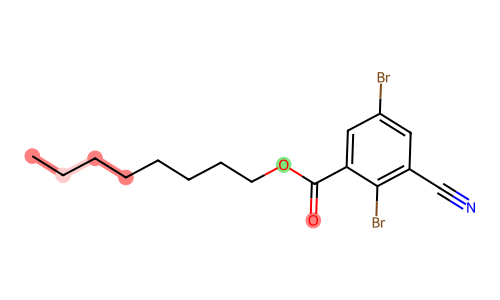

In [109]:
# Input SMILES string
smiles = "CCCCCCCCOC(=O)c1cc(Br)cc(C#N)c1Br"  # Replace with your SMILES string

# Convert SMILES to a molecule object
mol = Chem.MolFromSmiles(smiles)

# Prepare the molecule for drawing
Chem.rdDepictor.Compute2DCoords(mol)

# Set up atom contributions for highlighting (example values, modify as needed)
highlight_atoms = [0, 1, 2, 3, 8, 10]
highlight_colors = {0: (1.0, 0.5, 0.5), 1: (1.0, 0.8, 0.8), 8: (0.5, 0.9, 0.5)}

# Create a drawing object
drawer = rdMolDraw2D.MolDraw2DSVG(500, 300)  # SVG rendering for Jupyter
drawer.drawOptions().highlightColour = (0.8, 0.3, 0.3)  # Default highlight color
drawer.DrawMolecule(
    mol, highlightAtoms=highlight_atoms, highlightAtomColors=highlight_colors
)
drawer.FinishDrawing()

# Render SVG directly in Jupyter
svg = drawer.GetDrawingText()
display(SVG(svg))

## Classes

In [49]:
class XGBoostWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.best_model = None
        self.best_param = {'max_depth': 4, 'learning_rate': 0.2413394947754844, 'n_estimators': 129, 'min_child_weight': 4, 'gamma': 0.829607086182452, 'subsample': 0.8178363706444699, 'colsample_bytree': 0.5997780400509449, 'lambda': 0.006928053898643382, 'alpha': 0.1287756812330165}
        
    def fit(self, X, y):
        model = xgb.XGBClassifier()
        
        best_params = self.best_param     
        # Fit the final model with early stopping
        self.best_model = xgb.XGBClassifier(**best_params, early_stopping_rounds=10, eval_metric="logloss")
        self.best_model.fit(X, y, eval_set=[(X, y)], verbose=False)
        
        return self

    def predict(self, X):
        if self.best_model is None:
            raise Exception("Model is not fitted yet")
        return self.best_model.predict(X)
    
    def predict_proba(self, X):
        if self.best_model is None:
            raise Exception("Model is not fitted yet")
        return self.best_model.predict_proba(X)

## Pipline

In [ ]:
df = pd.read_excel(file_path)
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

y = y.replace({'I': 1, 'NI': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

In [51]:
# Wrapping functions inside FunctionTransformer correctly
descriptor_transformer = FunctionTransformer(lambda df: calculate_descriptors(df), validate=False)
drop_transformer = FunctionTransformer(lambda df: drop_columns(df), validate=False)
#fingerprint_transformer = FunctionTransformer(lambda df: calculate_fingerprint(df), validate=False)
outliers_transformer = FunctionTransformer(lambda df: detect_outliers(df), validate=False)
feature_selection_t = FunctionTransformer(lambda df: feature_selection(df), validate=False)
scaler = MinMaxScaler()
label_encoder = LabelEncoder()
imputer = SimpleImputer(strategy='mean')

In [52]:
# Define the pipeline with the transformers
pipeline = Pipeline(steps=[
    ('descriptor_transformer', descriptor_transformer),
    #('fingerprint_transformer', fingerprint_transformer),
    ('drop_transformer', drop_transformer),
    ('imputer', imputer),
    ('outliers_transformer', outliers_transformer),
    ('feature_selection', feature_selection_t),
    ('scaler', scaler),
    ('classifier', XGBoostWrapper())
])

In [70]:
# Define the pipeline with the transformers
pipeline = Pipeline(steps=[
    ('classifier', XGBoostWrapper())
])

In [ ]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
predictions = pipeline.predict(X_train)
print(predictions)

In [ ]:
y_pred_test = pipeline.predict(X_test)

# Make predictions on the training set using the fitted pipeline
y_pred_train = pipeline.predict(X_train)

# Get predicted probabilities for the test set (this uses the pipeline's classifier)
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

# Print the evaluation scores
print_score(y_train, y_pred_train, y_test, y_pred_test)